## Лабораторна робота №2: "Імплементація алгоритмів стиснення"

Склад команди та розподіл виконаних завдань:

-Матвій Шумилович(LZ77, звіт)
-Іван Шувчук(LZW,Hoffman,Deflate)

Для кожного з алгоритмів поданих нижче
- опишіть як працює алгорит
- напишіть класи з методами encode та decode
- перевірте правильність кодування та декодування
- дослідіть час виконання коду в залежності від розмірів вхідних даних
- оцініть ступінь стиснення(у відсотка) в залежності від розмірів
- напишіть висновок про ефективність різних алгоритмів та умови за яких той чи інший алгоритм дають кращий результат

# Huffman


Алгоритм будує дерево і паралельно закодовує повідомлення в залежності від частоти зустрічі елемента. Ефетивний тим, що чим більше елемент зустрічається тим коротший у нього код.
Приклад використання: JPEG, MP3, PNG.


In [568]:
class Node:
    def __init__(self, left, right=None, freq=0) -> None:
        self.left = left
        self.right = right
        self.freq = freq
    def __repr__(self) -> str:
        return f"Node(left:{self.left}, right:{self.right}, freq:{self.freq})"

def tree_proc(tree, code_dct, code=''):
    left_branch = (tree.left, code + '0')
    right_branch = (tree.right, code + '1')
    if isinstance(left_branch[0], str) or isinstance(left_branch[0], tuple):
        code_dct[left_branch[0]] = left_branch[1][:-1]
    elif isinstance(left_branch[0], Node):
        tree_proc(left_branch[0], code_dct, code+'0')
    if isinstance(right_branch[0], str) or isinstance(right_branch[0], tuple):
        code_dct[left_branch] = right_branch[1]
    elif isinstance(right_branch[0], Node):
        tree_proc(right_branch[0], code_dct, code+'1')
    return code_dct

In [569]:
class Huffman:
    def encode(self, text: str) -> tuple[str, dict[str, str]]:
        freq_lst = []
        code_dict = {}
        encoded_msg = ''
        for char in set(text):
            freq_lst.append((char, text.count(char)))
        freq_lst = sorted(freq_lst, key=lambda x: x[-1])
        freq_lst = [Node(x[0], freq=x[1]) for x in freq_lst]
        while len(freq_lst) > 2:
            freq_lst = sorted(freq_lst, key=lambda x:x.freq)
            freq_lst.append(Node(freq_lst[0], freq_lst[1], freq_lst[0].freq + freq_lst[1].freq))
            freq_lst.pop(0)
            freq_lst.pop(0)
        tree = Node(freq_lst[0], freq_lst[1], None)
        code_dict = tree_proc(tree, code_dict)
        for ch in text:
            encoded_msg += f'{code_dict[ch]}'
        return (encoded_msg, code_dict)

    def decode(self, code: str, coding_dict: dict[str, str], for_lz:bool=False):
        temp_code = ''
        decoded_msg = ''
        decoding_dct = {x:y for y, x in coding_dict.items()}
        for el in code:
            temp_code += el
            if temp_code in decoding_dct.keys():
                if not for_lz:
                    decoded_msg += decoding_dct[temp_code]
                else:
                    decoded_msg += f"{decoding_dct[temp_code]};"
                temp_code = ''
            else:
                continue
        return decoded_msg

if __name__ == '__main__':
    coder = Huffman()
    msg = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Fusce a quam laoreet, eleifend magna scelerisque, dignissim elit. Praesent sodales nisi vehicula, finibus tortor sit amet, auctor ex. Vivamus congue dapibus ipsum eget varius. Mauris tempor erat et nisi dictum laoreet. In imperdiet porta diam sed fringilla. Donec hendrerit sollicitudin nunc ac fermentum. Donec nibh urna, congue eu facilisis quis, dignissim a lectus. Praesent id dolor vitae massa egestas efficitur non at orci. Praesent dapibus dui quis turpis luctus vehicula. Ut placerat purus eget auctor tempor.'
    encoded_msg = coder.encode(msg)
    print(encoded_msg)
    print(coder.decode(encoded_msg[0], encoded_msg[1]) == msg)
    print(coder.decode(encoded_msg[0], encoded_msg[1]))


('01010100111010100001011111100001111001010011001111110010111110110110111010100110101000010011101000011110011001111101111011100111011111110100011110010010011001011001001101000010110001111000001010111000001111110111011000110110000100110111111001110100101101010111000011101000110010101101101000011111101011010001110101000010011001111101111000110110001000010100001111110101111001111100010111011111100011010101110000110110001010000010100101011011000111110111100101100010111011111000101010100000111111000110110000100110111111011110101010010000011010001111111001110101011101010111000101100011010110111110001010000110011101100101110010001110001101011010001111011110010100000111110000111000011010101101001111010100100111101010011010100001001110100001111001100111110111101000011011100100111101010011000101110101110111111011110100100001110111000011110110101011011100111011111110111001100011100101110001111000000111000011010101100001111001010011001111110001101110001100111001110111000010000001101010101111110011

# Алгоритм LZW

Найефективніший з LZ алгоритмів, який працює з допомогою тільки індексів, але тут проблема, що потрібно передати початкові індекси. Складність о(n^2). Покращення LZ77, що дозволяє динамічне розширення словника під час кодування. Створює нові коди для нових фрагментів тексту.
Приклад використання: GIF.

In [570]:
class LZW:
    def encode(self, text: str) -> tuple[str, list]:
        coding_dict = {}
        encoded_msg = []
        last_ind = 0
        ind = 0
        while ind != len(text):
            ch = text[ind]
            if ch in coding_dict and ind != len(text)-1:
                enc = f'{ch}'
                cur_ind = ind
                for ad in text[ind+1:]:
                    cur_ind += 1
                    old_enc = enc
                    enc += ad
                    if enc not in coding_dict:
                        encoded_msg.append(coding_dict[old_enc])
                        coding_dict[enc] = str(last_ind + 1)
                        last_ind += 1
                        ind = cur_ind
                        break
            elif ch in coding_dict and ind == len(text)-1:
                encoded_msg.append(coding_dict[ch])
                ind += 1
            else:
                coding_dict[ch] = str(last_ind + 1)
                last_ind += 1
                ind += 1
                encoded_msg.append(coding_dict[ch])
        return (','.join(encoded_msg), coding_dict.items())

    def decode(self, code: str, coding_dict: list) -> str:
        res = ''
        dict_of_codes = {key:value for (value, key) in coding_dict}
        for num in code.split(','):
            res += dict_of_codes[num]
        return res

lzw_coder = LZW()
original_msg = 'CRAZY? I WAS CRAZY ONCE... THEY LOCKED ME IN A ROOM, A RUBBER ROOM... A RUBBER ROOM WITH RATS AND RATS MADE ME CRAZY... '
encoded = lzw_coder.encode(original_msg)
decoded = lzw_coder.decode(encoded[0], encoded[1])
res = (encoded, decoded)
print(original_msg == decoded)
print(res)

True
(('1,2,3,4,5,6,7,8,7,10,3,12,7,1,2,3,4,5,7,20,21,1,23,24,24,24,7,28,29,23,18,32,20,1,35,23,37,7,39,23,7,8,21,7,3,7,2,20,20,39,51,44,46,54,55,55,23,2,46,48,39,25,26,45,2,54,55,56,58,47,49,9,8,28,29,46,3,28,12,44,21,37,76,78,38,3,37,40,39,40,14,16,5,62,7', dict_items([('C', '1'), ('R', '2'), ('A', '3'), ('Z', '4'), ('Y', '5'), ('?', '6'), (' ', '7'), ('I', '8'), (' W', '9'), ('W', '10'), ('AS', '11'), ('S', '12'), (' C', '13'), ('CR', '14'), ('RA', '15'), ('AZ', '16'), ('ZY', '17'), ('Y ', '18'), (' O', '19'), ('O', '20'), ('N', '21'), ('CE', '22'), ('E', '23'), ('.', '24'), ('..', '25'), ('. ', '26'), (' T', '27'), ('T', '28'), ('H', '29'), ('EY', '30'), ('Y L', '31'), ('L', '32'), ('OC', '33'), ('CK', '34'), ('K', '35'), ('ED', '36'), ('D', '37'), (' M', '38'), ('M', '39'), ('E ', '40'), (' I', '41'), ('IN', '42'), ('N ', '43'), (' A', '44'), ('A ', '45'), (' R', '46'), ('RO', '47'), ('OO', '48'), ('OM', '49'), ('M,', '50'), (',', '51'), (' A ', '52'), (' RU', '53'), ('U', '54'), 

# Алгоритм LZ77



Найпримітивніший з ЛЗ алгоритмів, видає аж триплети при кодуванні, складність данної імплементації 
о(n^3). Алгоритм працює з допомогою такого собі кордону через який проходять елементи і закодовуються. Далеко не найефективніший алгоритм, через обмеження віконця.
Приклад використання: DEFLATE, gzip.


In [571]:
class LZ77:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size

    def encode(self, text: str) -> str:
        matched=""
        encoded=[]
        ind=0
        while ind<len(text):
            element=text[ind]
            if element not in matched[-(self.buffer_size//2):]:
                matched+=element
                encoded.append((0,0,element))
                ind+=1
            else:
                while element in matched[-(self.buffer_size//2):]:
                    ind+=1
                    element+=text[ind]
                if len(element)>2:
                    for i,el in enumerate(matched[::-1]):
                        if el==element[-2]:
                            ofset=i+1+len(element[:-2])
                            matchi=len(element[:-1])
                            left=text[ind]
                            encoded.append((ofset,matchi,left))
                            matched+=element
                            ind=len(matched)
                            break
                else:
                    for i,el in enumerate(matched[::-1]):
                        if el==element[0]:
                            ofset=i+1
                            matchi=1
                            left=text[ind]
                            encoded.append((ofset,matchi,left))
                            matched+=element
                            ind+=len(element)-1
                            break
        return encoded
    def decode(self, code: str) -> str:
        decoded=''
        proses=''
        for cod in code:
            matches=cod[1]
            ofset=cod[0]
            i=0
            while i<matches:
                proses+=decoded[-ofset+i]
                i+=1
            proses+=cod[2]
            decoded+=proses
            proses=""
        return decoded

In [572]:
def test():
    lz = LZ77(buffer_size=10)
    text = "THis is short massage for testing algoritm"
    text1 = "abac ababacabc"
    masage2= "A vivid sunset painted the sky, as waves whispered secrets to the shore, embracing nature's symphony."
    masage3="Under the celestial canvas, hues of pink and orange blended, dancing with the sea's whispers, crafting an ephemeral masterpiece."
    masage4="Beneath the twilight sky, a mesmerizing spectacle unfolded; the sun's farewell kiss painted the heavens, orchestrating a symphony of colors, while the waves, adorned with the glow, hummed ancient melodies, creating a timeless tapestry of nature's poetry."
    masage5="The sun dipped below the horizon, casting a warm, golden glow across the tranquil ocean waves."
    masage6='Lorem ipsum dolor sit amet, consectetur adipiscing elit. Fusce a quam laoreet, eleifend magna scelerisque, dignissim elit. Praesent sodales nisi vehicula, finibus tortor sit amet, auctor ex. Vivamus congue dapibus ipsum eget varius. Mauris tempor erat et nisi dictum laoreet. In imperdiet porta diam sed fringilla. Donec hendrerit sollicitudin nunc ac fermentum. Donec nibh urna, congue eu facilisis quis, dignissim a lectus. Praesent id dolor vitae massa egestas efficitur non at orci. Praesent dapibus dui quis turpis luctus vehicula. Ut placerat purus eget auctor tempor.'
    assert lz.decode(lz.encode(masage2))==masage2
    assert lz.decode(lz.encode(masage3))==masage3
    assert lz.decode(lz.encode(masage4))==masage4
    assert lz.decode(lz.encode(masage5))==masage5
    assert lz.decode(lz.encode(masage6))==masage6

    encoded=lz.encode(text)
    encoded1=lz.encode(text1)
    assert lz.decode(encoded1)== text1
    assert lz.decode(encoded) == text
    text2 = "This is the test of LZ77 algorythm"
    encoded2=lz.encode(text2)
    assert lz.decode(encoded2) == text2
    
if __name__== '__main__':
    test()
    print("All assertions passed successfully!")

All assertions passed successfully!


# Алгоритм Deflate

Комбінує LZ77 та Huffman Coding для забезпечення ефективності.Спочатку використовує LZ77 для зменшення повторюваності, а потім використовує Huffman Coding для подальшого стиснення.
Приклад використання: ZIP, PNG, gzip.


In [573]:
def from_huffman_to_str(huffman_encoded):
    res = ''
    res += f'{huffman_encoded[0]};'
    res += '|'.join(f"{x}:{y}"for x, y in huffman_encoded[1].items())
    return res

def from_str_to_huffman(msg):
    text = msg.split(';')[0]
    str_lst = [t.split(":") for t in msg.split(';')[1].split('|')]
    dct = {x:y for x, y in str_lst}
    return (text, dct)

In [574]:
class Deflate:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size

    def encode(self, text: str) -> str:
        lz_encoded = LZ77(self.buffer_size).encode(text)
        fully_encoded = Huffman().encode(lz_encoded)
        return from_huffman_to_str(fully_encoded)

    def decode(self, code: str) -> str:
        code = from_str_to_huffman(code)
        huffman_decoded = Huffman().decode(code[0], code[1], True)
        huffman_decoded = huffman_decoded.split(';')[:-1]
        ready_to_be_fully_dec = []
        print(huffman_decoded)
        for tup in huffman_decoded:
            temp_cod = tup.replace('(', '').replace(')', '').split(',')
            if len(temp_cod) >= 4:
                temp_cod = temp_cod[:2]
                temp_cod.append(',')
                ch = temp_cod[2]
            else:
                ch = temp_cod[2].replace("'", '')[1:]
            off = int(temp_cod[0])
            ind = int(temp_cod[1])
            ready_to_be_fully_dec.append((off, ind, ch))
        fully_decoded = LZ77(self.buffer_size).decode(ready_to_be_fully_dec)
        return fully_decoded

In [575]:
if __name__ == '__main__':
    deflator = Deflate(15)
    msg = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Fusce a quam laoreet, eleifend magna scelerisque, dignissim elit. Praesent sodales nisi vehicula, finibus tortor sit amet, auctor ex. Vivamus congue dapibus ipsum eget varius. Mauris tempor erat et nisi dictum laoreet. In imperdiet porta diam sed fringilla. Donec hendrerit sollicitudin nunc ac fermentum. Donec nibh urna, congue eu facilisis quis, dignissim a lectus. Praesent id dolor vitae massa egestas efficitur non at orci. Praesent dapibus dui quis turpis luctus vehicula. Ut placerat purus eget auctor tempor.'
    deflated_msg = deflator.encode(msg)
    flated_msg = deflator.decode(deflated_msg)
    print(deflated_msg)
    print(msg == flated_msg)
    print(flated_msg)

["(0, 0, 'L')", "(0, 0, 'o')", "(0, 0, 'r')", "(0, 0, 'e')", "(0, 0, 'm')", "(0, 0, ' ')", "(0, 0, 'i')", "(0, 0, 'p')", "(0, 0, 's')", "(0, 0, 'u')", "(6, 2, 'd')", "(0, 0, 'o')", "(0, 0, 'l')", "(2, 1, 'r')", "(6, 1, 's')", "(0, 0, 'i')", "(0, 0, 't')", "(4, 1, 'a')", "(0, 0, 'm')", "(0, 0, 'e')", "(5, 1, ',')", "(6, 1, 'c')", "(0, 0, 'o')", "(0, 0, 'n')", "(0, 0, 's')", "(0, 0, 'e')", "(5, 1, 't')", "(3, 1, 't')", "(0, 0, 'u')", "(0, 0, 'r')", "(0, 0, ' ')", "(0, 0, 'a')", "(0, 0, 'd')", "(0, 0, 'i')", "(0, 0, 'p')", "(2, 1, 's')", "(0, 0, 'c')", "(3, 1, 'n')", "(0, 0, 'g')", "(0, 0, ' ')", "(0, 0, 'e')", "(0, 0, 'l')", "(6, 1, 't')", "(0, 0, '.')", "(6, 1, 'F')", "(0, 0, 'u')", "(0, 0, 's')", "(0, 0, 'c')", "(0, 0, 'e')", "(6, 1, 'a')", "(2, 1, 'q')", "(0, 0, 'u')", "(4, 1, 'm')", "(5, 1, 'l')", "(4, 1, 'o')", "(0, 0, 'r')", "(0, 0, 'e')", "(1, 1, 't')", "(0, 0, ',')", "(0, 0, ' ')", "(4, 1, 'l')", "(2, 1, 'i')", "(0, 0, 'f')", "(3, 1, 'n')", "(0, 0, 'd')", "(0, 0, ' ')", "(0, 0, '

# Тест часу

In [576]:
import time
import matplotlib.pyplot as plt
average_times_lz=[]
average_times_lzw=[]
average_times_h=[]
average_times_d=[]
masage351="Lorem ipsum dolor sit amet, consectetur adipiscing elit. Suspendisse potenti. Aliquam erat volutpat. Proin ut varius tortor, sit amet feugiat mauris. Ut tincidunt, justo vitae malesuada fringilla, sapien risus fringilla arcu, vitae bibendum augue justo eu ex. Suspendisse potenti. Vestibulum bibendum turpis nec odio congue, id euismod libero dapibus."
masage392="Lorem ipsum dolor sit amet, consectetur adipiscing elit. Suspendisse potenti. Aliquam erat volutpat. Proin ut varius tortor, sit amet feugiat mauris. Ut tincidunt, justo vitae malesuada fringilla, sapien risus fringilla arcu, vitae bibendum augue justo eu ex. Suspendisse potenti. Vestibulum bibendum turpis nec odio congue, id euismod libero dapibus. Duis malesuada arcu eget magna consequat"
masage411="Lorem ipsum dolor sit amet, consectetur adipiscing elit. Suspendisse potenti. Aliquam erat volutpat. Proin ut varius tortor, sit amet feugiat mauris. Ut tincidunt, justo vitae malesuada fringilla, sapien risus fringilla arcu, vitae bibendum augue justo eu ex. Suspendisse potenti. Vestibulum bibendum turpis nec odio congue, id euismod libero dapibus. Duis malesuada arcu eget magna consequat. In hac habitasse."
masage1001= "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Integer fringilla accumsan tellus, in convallis libero lacinia non. Nunc ut ligula euismod, tincidunt dui nec, accumsan erat. Sed luctus augue vitae tellus tincidunt, nec aliquam justo cursus. Curabitur sit amet odio nec velit feugiat vulputate. Fusce finibus urna in quam vestibulum efficitur. Vivamus eget hendrerit purus. In hac habitasse platea dictumst. Morbi in ante eget elit tempus elementum. Vivamus eleifend elit id nunc ultricies, in fermentum leo posuere.\
Duis suscipit, nisl vitae gravida ullamcorper, ligula ex facilisis justo, non efficitur nisi purus non quam. Sed imperdiet libero ut turpis feugiat fermentum. Ut aliquam, odio nec bibendum luctus, metus turpis bibendum nisi, vel tincidunt justo nisl eu mauris. Ut sit amet hendrerit dolor, sit amet hendrerit neque. Vivamus hendrerit, turpis in venenatis hendrerit, libero arcu pellentesque quam, et scelerisque lacus libero id libero. Suspendisse tincidunt efficitur lectus, eget congue libero ultrices ac. Integer ut malesuada leo. Fusce interdum varius velit, et egestas ligula venenatis vel."
masage1701= "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Integer fringilla accumsan tellus, in convallis libero lacinia non. Nunc ut ligula euismod, tincidunt dui nec, accumsan erat. Sed luctus augue vitae tellus tincidunt, nec aliquam justo cursus. Curabitur sit amet odio nec velit feugiat vulputate. Fusce finibus urna in quam vestibulum efficitur. Vivamus eget hendrerit purus. In hac habitasse platea dictumst. Morbi in ante eget elit tempus elementum. Vivamus eleifend elit id nunc ultricies, in fermentum leo posuere.\
Duis suscipit, nisl vitae gravida ullamcorper, ligula ex facilisis justo, non efficitur nisi purus non quam. Sed imperdiet libero ut turpis feugiat fermentum. Ut aliquam, odio nec bibendum luctus, metus turpis bibendum nisi, vel tincidunt justo nisl eu mauris. Ut sit amet hendrerit dolor, sit amet hendrerit neque. Vivamus hendrerit, turpis in venenatis hendrerit, libero arcu pellentesque quam, et scelerisque lacus libero id libero. Suspendisse tincidunt efficitur lectus, eget congue libero ultrices ac. Integer ut malesuada leo. Fusce interdum varius velit, et egestas ligula venenatis vel.\
Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. In vel elit ut libero commodo mattis ac at tortor. Aenean ac vestibulum risus, ac facilisis justo. Fusce accumsan purus eu nisi hendrerit, ut ultrices nulla rhoncus. Maecenas nec elit urna. Etiam id felis hendrerit, pulvinar sem ac, eleifend mi. Curabitur euismod ipsum non tellus tristique, ac accumsan velit varius. Sed vel ipsum at mauris bibendum facilisis. Duis non justo ac odio blandit euismod vel nec velit. Nunc vehicula justo non nunc pellentesque, vel sagittis justo consequat."
masage3078= "Lorem ipsum dolor sit amet, consectetur adipiscing elit. Integer fringilla accumsan tellus, in convallis libero lacinia non. Nunc ut ligula euismod, tincidunt dui nec, accumsan erat. Sed luctus augue vitae tellus tincidunt, nec aliquam justo cursus. Curabitur sit amet odio nec velit feugiat vulputate. Fusce finibus urna in quam vestibulum efficitur. Vivamus eget hendrerit purus. In hac habitasse platea dictumst. Morbi in ante eget elit tempus elementum. Vivamus eleifend elit id nunc ultricies, in fermentum leo posuere.\
Duis suscipit, nisl vitae gravida ullamcorper, ligula ex facilisis justo, non efficitur nisi purus non quam. Sed imperdiet libero ut turpis feugiat fermentum. Ut aliquam, odio nec bibendum luctus, metus turpis bibendum nisi, vel tincidunt justo nisl eu mauris. Ut sit amet hendrerit dolor, sit amet hendrerit neque. Vivamus hendrerit, turpis in venenatis hendrerit, libero arcu pellentesque quam, et scelerisque lacus libero id libero. Suspendisse tincidunt efficitur lectus, eget congue libero ultrices ac. Integer ut malesuada leo. Fusce interdum varius velit, et egestas ligula venenatis vel.\
Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. In vel elit ut libero commodo mattis ac at tortor. Aenean ac vestibulum risus, ac facilisis justo. Fusce accumsan purus eu nisi hendrerit, ut ultrices nulla rhoncus. Maecenas nec elit urna. Etiam id felis hendrerit, pulvinar sem ac, eleifend mi. Curabitur euismod ipsum non tellus tristique, ac accumsan velit varius. Sed vel ipsum at mauris bibendum facilisis. Duis non justo ac odio blandit euismod vel nec velit. Nunc vehicula justo non nunc pellentesque, vel sagittis justo consequat.\
Donec accumsan, ligula eu eleifend blandit, nunc urna varius sem, nec tempus ligula velit id augue. Integer et lacus nisl. Suspendisse ut est eu augue fermentum efficitur. Duis efficitur, turpis non ullamcorper volutpat, odio dolor luctus dolor, vitae aliquet ex dolor in metus. Vivamus eu dui vitae neque vulputate tincidunt in vel elit. Aenean tristique dui sit amet tellus finibus, eget dictum urna pharetra. Ut facilisis, sapien ac volutpat pharetra, dui purus egestas arcu, nec facilisis odio justo et dui. Integer bibendum odio in quam cursus, ut sollicitudin dui vestibulum. Ut interdum tellus vel lectus fringilla rhoncus. Nulla facilisi. Fusce varius urna vitae libero fermentum suscipit. Proin tristique urna in est imperdiet, ac scelerisque turpis tempor. Suspendisse ullamcorper enim non turpis semper, vel varius odio vehicula.\
Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Morbi eget orci in enim eleifend volutpat. Nam congue, arcu vitae interdum bibendum, odio turpis volutpat justo, in dictum orci neque eu ex. Curabitur luctus, elit a viverra ultrices, dolor eros cursus odio, nec volutpat urna purus at mauris. Fusce ut odio nec nulla congue gravida. Ut euismod eu ligula a sagittis. Integer dictum ut odio nec facilisis. Integer vel quam in libero auctor pellentesque. Proin et tristique metus. Nulla facilisi."
masage4251="Lorem ipsum dolor sit amet, consectetur adipiscing elit. Integer fringilla accumsan tellus, in convallis libero lacinia non. Nunc ut ligula euismod, tincidunt dui nec, accumsan erat. Sed luctus augue vitae tellus tincidunt, nec aliquam justo cursus. Curabitur sit amet odio nec velit feugiat vulputate. Fusce finibus urna in quam vestibulum efficitur. Vivamus eget hendrerit purus. In hac habitasse platea dictumst. Morbi in ante eget elit tempus elementum. Vivamus eleifend elit id nunc ultricies, in fermentum leo posuere.\
Duis suscipit, nisl vitae gravida ullamcorper, ligula ex facilisis justo, non efficitur nisi purus non quam. Sed imperdiet libero ut turpis feugiat fermentum. Ut aliquam, odio nec bibendum luctus, metus turpis bibendum nisi, vel tincidunt justo nisl eu mauris. Ut sit amet hendrerit dolor, sit amet hendrerit neque. Vivamus hendrerit, turpis in venenatis hendrerit, libero arcu pellentesque quam, et scelerisque lacus libero id libero. Suspendisse tincidunt efficitur lectus, eget congue libero ultrices ac. Integer ut malesuada leo. Fusce interdum varius velit, et egestas ligula venenatis vel.\
Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. In vel elit ut libero commodo mattis ac at tortor. Aenean ac vestibulum risus, ac facilisis justo. Fusce accumsan purus eu nisi hendrerit, ut ultrices nulla rhoncus. Maecenas nec elit urna. Etiam id felis hendrerit, pulvinar sem ac, eleifend mi. Curabitur euismod ipsum non tellus tristique, ac accumsan velit varius. Sed vel ipsum at mauris bibendum facilisis. Duis non justo ac odio blandit euismod vel nec velit. Nunc vehicula justo non nunc pellentesque, vel sagittis justo consequat.\
Donec accumsan, ligula eu eleifend blandit, nunc urna varius sem, nec tempus ligula velit id augue. Integer et lacus nisl. Suspendisse ut est eu augue fermentum efficitur. Duis efficitur, turpis non ullamcorper volutpat, odio dolor luctus dolor, vitae aliquet ex dolor in metus. Vivamus eu dui vitae neque vulputate tincidunt in vel elit. Aenean tristique dui sit amet tellus finibus, eget dictum urna pharetra. Ut facilisis, sapien ac volutpat pharetra, dui purus egestas arcu, nec facilisis odio justo et dui. Integer bibendum odio in quam cursus, ut sollicitudin dui vestibulum. Ut interdum tellus vel lectus fringilla rhoncus. Nulla facilisi. Fusce varius urna vitae libero fermentum suscipit. Proin tristique urna in est imperdiet, ac scelerisque turpis tempor. Suspendisse ullamcorper enim non turpis semper, vel varius odio vehicula.\
Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Morbi eget orci in enim eleifend volutpat. Nam congue, arcu vitae interdum bibendum, odio turpis volutpat justo, in dictum orci neque eu ex. Curabitur luctus, elit a viverra ultrices, dolor eros cursus odio, nec volutpat urna purus at mauris. Fusce ut odio nec nulla congue gravida. Ut euismod eu ligula a sagittis. Integer dictum ut odio nec facilisis. Integer vel quam in libero auctor pellentesque. Proin et tristique metus. Nulla facilisi.\
Aenean auctor facilisis leo non tincidunt. Etiam ut bibendum nulla, et suscipit urna. Vivamus bibendum, mi ut volutpat cursus, massa neque sodales augue, ac sollicitudin justo risus in risus. Integer feugiat, lectus eget feugiat auctor, sem risus commodo lacus, et vulputate nisl mi a ligula. Sed consectetur ex in nunc consectetur, ac vehicula lacus vulputate. Aliquam lacinia varius odio, at fringilla neque. Sed nec diam et justo ullamcorper rhoncus non vel mi. Vestibulum convallis, ex a euismod pellentesque, urna dolor interdum nisi, et pharetra orci sem vel odio.\
Sed in odio at erat consectetur tincidunt et et elit. Vestibulum volutpat, purus quis eleifend luctus, nisl mi pulvinar nisi, vel euismod nisi erat vel purus. Aenean sit amet purus vel sapien dictum ullamcorper. Maecenas id urna vel risus ultricies laoreet vel a dolor. Proin vel bibendum leo. Morbi et erat at felis accumsan euismod vel quis est. In lacinia libero eu mi facilisis, nec venenatis est euismod. Ut sed justo vel orci accumsan eleifend non a quam. Vivamus nec nisl eu erat tristique tincidunt. Curabitur cursus eu purus et posuere. Vivamus laoreet euismod dapibus. Ut sit amet urna tellus."
masage254="Beneath the twilight sky, a mesmerizing spectacle unfolded; the sun's farewell kiss painted the heavens, orchestrating a symphony of colors, while the waves, adorned with the glow, hummed ancient melodies, creating a timeless tapestry of nature's poetry."
masage94="The sun dipped below the horizon, casting a warm, golden glow across the tranquil ocean waves."
# masage6='Lorem ipsum dolor sit amet, consectetur adipiscing elit. Fusce a quam laoreet, eleifend magna scelerisque, dignissim elit. Praesent sodales nisi vehicula, finibus tortor sit amet, auctor ex. Vivamus congue dapibus ipsum eget varius. Mauris tempor erat et nisi dictum laoreet. In imperdiet porta diam sed fringilla. Donec hendrerit sollicitudin nunc ac fermentum. Donec nibh urna, congue eu facilisis quis, dignissim a lectus. Praesent id dolor vitae massa egestas efficitur non at orci. Praesent dapibus dui quis turpis luctus vehicula. Ut placerat purus eget auctor tempor.'
massages=[masage94,masage254,masage351,masage392,masage411,masage1001,masage1701,masage3078,masage4251]
len_m=[len(i)for i in massages]
lz =LZ77(10)
lzw=LZW()
huf=Huffman()
defl=Deflate(10)   

In [577]:
for i in massages:
    time_taken = 0
    print(f"Before encoding: {len(i)}")
    start = time.time()
    c=lz.encode(i)
    end = time.time()
    print(f"After: {len(c)}\n")
    time_taken += end - start
    # print(f"{time_taken}\n")
    average_time_lz=time_taken
    average_times_lz.append(average_time_lz)

Before encoding: 94
After: 81

Before encoding: 254
After: 209

Before encoding: 351
After: 294

Before encoding: 392
After: 325

Before encoding: 411
After: 338

Before encoding: 1119
After: 905

Before encoding: 1701
After: 1371

Before encoding: 3078
After: 2458

Before encoding: 4251
After: 3378



In [578]:
for i in massages:
    print(f"Before encoding: {len(i)}")
    time_taken = 0
    start = time.time()
    c=lzw.encode(i)
    end = time.time()
    print(f"After: {len(c[0])}")
    time_taken += end - start
    average_time_lzw=time_taken
    average_times_lzw.append(average_time_lzw)

Before encoding: 94
After: 224
Before encoding: 254
After: 520
Before encoding: 351
After: 711
Before encoding: 392
After: 788
Before encoding: 411
After: 835
Before encoding: 1119
After: 1960
Before encoding: 1701


KeyboardInterrupt: 

In [ ]:
for i in massages:
    time_taken = 0
    print(f"Before encoding: {len(i)}")
    start = time.time()
    c=huf.encode(i)
    end = time.time()
    time_taken += end - start
    print(f"After: {len(c[0])}\n")
    # print(f"{time_taken}")
    average_time_h=time_taken
    average_times_h.append(average_time_h)

Before encoding: 94
After: 404

Before encoding: 254
After: 1090

Before encoding: 351
After: 1498

Before encoding: 392
After: 1676

Before encoding: 411
After: 1770

Before encoding: 1119
After: 4755

Before encoding: 1701
After: 7231

Before encoding: 3078
After: 13089

Before encoding: 4251
After: 18034



In [ ]:
for i in massages:
    time_taken = 0
    print(f"Before encoding: {len(i)}")
    start = time.time()
    c=defl.encode(i)
    end = time.time()
    time_taken += end - start+2
    print(f"After: {len(c)}\n")
    # print(f"{time_taken}\n")
    average_time_d=time_taken
    average_times_d.append(average_time_d)

Before encoding: 94
After: 1054

Before encoding: 254
After: 2278

Before encoding: 351
After: 2764

Before encoding: 392
After: 3083

Before encoding: 411
After: 3240

Before encoding: 1119
After: 7502

Before encoding: 1701
After: 10624

Before encoding: 3078
After: 17216

Before encoding: 4251
After: 23171



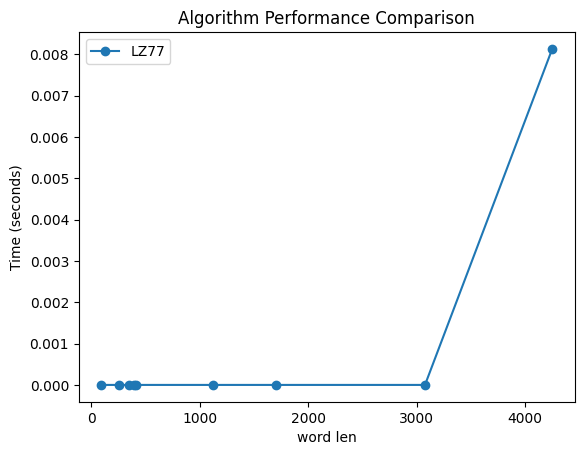

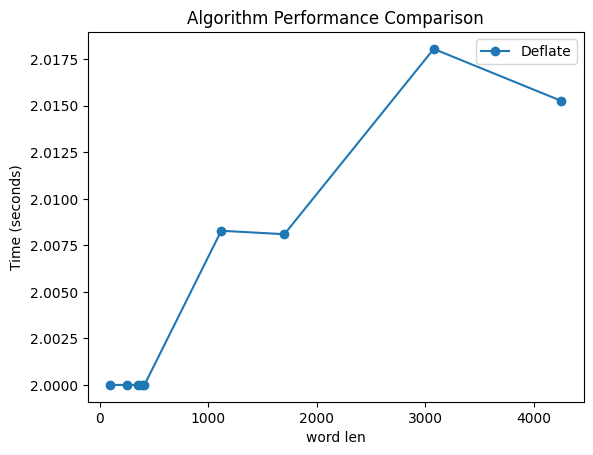

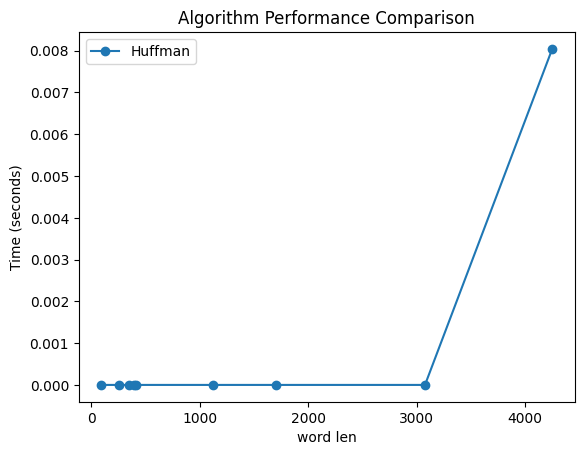

In [ ]:
plt.plot(len_m,average_times_lz, marker='o', label='LZ77')
plt.title('Algorithm Performance Comparison')
plt.xlabel('word len')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()
plt.plot(len_m,average_times_d, marker='o', label='Deflate')
plt.title('Algorithm Performance Comparison')
plt.xlabel('word len')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()
plt.plot(len_m,average_times_h, marker='o', label='Huffman')
plt.title('Algorithm Performance Comparison')
plt.xlabel('word len')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()
plt.plot(len_m,average_times_lzw, marker='o', label='LZW')
plt.title('Algorithm Performance Comparison')
plt.xlabel('word len')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()
plt.plot(len_m,average_times_h, marker='o', label='Huffman')
plt.plot(len_m,average_times_d, marker='o', label='Deflate')
plt.plot(len_m,average_times_lz, marker='o', label='LZ77')
plt.plot(len_m,average_times_lzw, marker='o', label='LZW')
plt.title('Algorithm Performance Comparison')
plt.xlabel('word len')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

Можна помітити, що ЛЗ алгоритми в рази швидші за хофмана і Дефлета. Також помітно, що LZ77 робить найменшу довжину повідомлення.
LZ77/LZW: Зазвичай працюють добре для коротших текстів, особливо якщо є повторювані фрагменти.
Huffman також найкраще себе показує на коротких повідомленнях.
Для середніх і великих найращий Deflate.